# Building model with Keras pipeline (WIP) #


In [1]:
# Import the packages

# Utilities
import os
import logging

# For visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

# For modelling
import tensorflow as tf
from tensorflow import keras
from tensorflow import feature_column as fc
from tensorflow.keras import layers, models

# Set TF logger to only print errors (dismiss warnings)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow logging (1: INFO, 2: WARNING and ERROR)
tf.get_logger().setLevel('ERROR')  # Suppress TensorFlow logging at the Python level

## Load dataset




Let's check that the files were copied correctly and look like we expect them to.

In [3]:
df = pd.read_csv('..\dataset\data_job_new_with_predicted_cat.csv')

In [4]:
df.head()

,ID,Company,Job_Title,YOE,Location,Est_Salary,Job_Description,Link,Min_level,Max_level,...,Data_Scientist_prob,Business_Analyst_prob,Business_Intelligence_prob,Others_prob,Data_Engineer,Data_Analyst,Data_Scientist,Business_Analyst,Business_Intelligence,Others
0,3617,FIDT,( Data ) Research Intern,0.0,HCM,65.0,Minimum 10 hours/week; Students complete at le...,https://www.linkedin.com/jobs/view/3631700502,0,0,...,3.320370e-04,1.420000e-05,4.020000e-09,8.928759e-01,0,0,0,0,0,1
1,1084,Kyanon Digital,Machine Learning Engineer Intern,0.0,HCM,85.0,"Familiar with Object-Oriented Programming, Mod...",https://glints.com/vn/opportunities/jobs/machi...,0,0,...,4.200000e-10,2.540000e-07,1.490000e-07,9.947981e-01,0,0,0,0,0,1
2,2526,Paditech,Blockchain Intern,0.0,HN,85.0,"3rd, 4th, 5th year students or have graduated ...",https://www.topcv.vn/viec-lam/thuc-tap-sinh-bl...,0,0,...,3.848903e-03,2.628318e-03,2.480000e-05,9.846249e-01,0,0,0,0,0,1
3,2858,Maico Group,BI Intern,0.0,HCM,85.0,The program will not be suitable for you who a...,https://www.careerlink.vn/tim-viec-lam/thuc-ta...,0,0,...,2.765148e-03,7.810333e-02,2.572874e-03,9.400327e-01,0,0,0,0,0,1
4,3423,DataGenius,Data Engineer | Data Analyst | AI Engineer,0.0,HCM,105.0,DataGenius company is recruiting Data Engineer...,https://www.facebook.com/groups/datanalyticsvn...,0,0,...,2.051680e-04,7.030000e-07,3.560000e-09,5.590000e-10,1,1,0,0,0,0


In [5]:
col_to_drop = ['Job_Title','Job_Description','ID', 'Company', 'Link', 'Data_Engineer_prob','Data_Analyst_prob', 'Data_Scientist_prob','Business_Analyst_prob','Business_Intelligence_prob','Others_prob']
clean_df=df.drop(columns=col_to_drop)
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3631 entries, 0 to 3630
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   YOE                    2974 non-null   float64
 1   Location               3621 non-null   object 
 2   Est_Salary             3377 non-null   float64
 3   Min_level              3631 non-null   int64  
 4   Max_level              3631 non-null   int64  
 5   VN                     3631 non-null   int64  
 6   Overseas               3631 non-null   int64  
 7   Remote                 3631 non-null   int64  
 8   Data_Engineer          3631 non-null   int64  
 9   Data_Analyst           3631 non-null   int64  
 10  Data_Scientist         3631 non-null   int64  
 11  Business_Analyst       3631 non-null   int64  
 12  Business_Intelligence  3631 non-null   int64  
 13  Others                 3631 non-null   int64  
dtypes: float64(2), int64(11), object(1)
memory usage: 397.3+

In [6]:
clean_df['Location'].unique()

array(['HCM', 'HN', 'Nha Trang', 'HCM, Remote*', 'Remote', 'Binh Duong',
       'Dong Nai', 'HCM*, Dong Nai', 'Da Nang', 'HCM, Remote',
       'HCM, Da Nang*, Remote*', nan, 'Khanh Hoa', 'An Giang', 'Can Tho',
       'VN', 'Bac Ninh, HN*', 'Quy Nhon', 'Bac Ninh', 'Hai Duong',
       'Quang Ngai', 'Gia Lai', 'Long An', 'Hung Yen, Hai Duong, Ha Noi',
       'Binh Dinh', 'VN, Remote', 'HCM, Binh Duong', 'HCM, Da Nang',
       'Quang Nam', 'BR-VT', 'HCM, Long An', 'Hoa Binh', 'Philippines',
       'HCM, Binh Duong, Dong Nai', 'Binh Duong, HCM', 'Hai Phong',
       'HCM, US*', 'Binh Duong, BR-VT', 'Malaysia, HN', 'Cambodia',
       'Da Nang, Japan*', 'Philipines', 'HCM, Khanh Hoa',
       'HCM, US*, Japan*', 'HCM, Australia*',
       'HCM, Singapore*, Australia*', 'Senior', 'HCM, Can Tho',
       'HCM, Cambodia', 'HCM, Da Nang, Remote', 'Thailand', 'HCM, HN',
       'Hong Kong', 'HCM, Dong Nai', 'Korea', 'Australia', 'Malaysia',
       'UK, Remote', 'Singapore',
       'VN*, HN, HCM, Da Nan

In [7]:
# Standardize the location variable
clean_df['Location'] = clean_df['Location'].str.replace(r'[^a-zA-Z0-9 ]', '')

# Replace typos and abbreviations
clean_df['Location'] = clean_df['Location'].replace({
    'HN': 'Ha Noi',
    'Philipines': 'Philippines'
})

# Replace 'None' and 'Senior' with 'Unspecified'
clean_df['Location'] = clean_df['Location'].replace({
    None: 'Unspecified',
    'Senior': 'Unspecified'
})

# Split values with multiple categories, keep only the least frequent category
def split_and_keep_least_frequent(categories):
    if pd.isna(categories):
        return 'Unspecified'
    else:
        # Split categories by comma
        category_list = [category.strip() for category in categories.split(',')]
        
        # Remove parenthesized content
        category_list = [category.split('(')[0].strip() for category in category_list]
        
        # Count occurrences of each category
        category_counts = pd.Series(category_list).value_counts()
        
        # Find the least frequent category
        least_frequent_category = category_counts.idxmin()
        
        return least_frequent_category

# Apply the function to the 'Location' column
clean_df['Location'] = clean_df['Location'].apply(split_and_keep_least_frequent)

# Display the cleaned unique values
print(clean_df['Location'].unique())


['HCM' 'Ha Noi' 'Nha Trang' 'Remote' 'Binh Duong' 'Dong Nai' 'HCM*'
 'Da Nang' 'Unspecified' 'Khanh Hoa' 'An Giang' 'Can Tho' 'VN' 'Bac Ninh'
 'Quy Nhon' 'Hai Duong' 'Quang Ngai' 'Gia Lai' 'Long An' 'Hung Yen'
 'Binh Dinh' 'Quang Nam' 'BR-VT' 'Hoa Binh' 'Philippines' 'Hai Phong'
 'Malaysia' 'Cambodia' 'Thailand' 'Hong Kong' 'Korea' 'Australia' 'UK'
 'Singapore' 'VN*' 'EU' 'Japan' 'Finland' 'Canada']


In [8]:
clean_df.dropna(subset='Est_Salary')
clean_df.fillna(value=0, inplace=True)

job_categories = ['Data_Engineer', 'Data_Analyst', 'Data_Scientist', 'Business_Analyst', 'Business_Intelligence','Others']
# Calculate the average YOE for each job category and round it
average_yoe_by_category = clean_df.groupby(job_categories)['YOE'].mean().round().reset_index()

# Fill in the missing 'YOE' values based on the job category
for _, row in average_yoe_by_category.iterrows():
    condition = (clean_df[job_categories] == tuple(row[job_categories])).all(axis=1)
    clean_df.loc[condition, 'YOE'] = row['YOE']

clean_df['Location'] = clean_df['Location'].astype(str)

clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3631 entries, 0 to 3630
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   YOE                    3631 non-null   float64
 1   Location               3631 non-null   object 
 2   Est_Salary             3631 non-null   float64
 3   Min_level              3631 non-null   int64  
 4   Max_level              3631 non-null   int64  
 5   VN                     3631 non-null   int64  
 6   Overseas               3631 non-null   int64  
 7   Remote                 3631 non-null   int64  
 8   Data_Engineer          3631 non-null   int64  
 9   Data_Analyst           3631 non-null   int64  
 10  Data_Scientist         3631 non-null   int64  
 11  Business_Analyst       3631 non-null   int64  
 12  Business_Intelligence  3631 non-null   int64  
 13  Others                 3631 non-null   int64  
dtypes: float64(2), int64(11), object(1)
memory usage: 397.3+

## Create an input pipeline


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Init global variables and encoder
LABEL_COLUMN = 'Est_Salary'  
NUMERIC_COLS = ['YOE', 'Min_level',
                'Max_level', 'VN',
                'Overseas', 'Remote', 
                'Data_Engineer','Data_Analyst','Data_Scientist',
                'Business_Analyst','Business_Intelligence','Others']
CATEGORICAL_COLS  = ['Location']
encoder = OneHotEncoder(sparse=False)
encoder.fit(clean_df[["Location"]])
encoded_categorical_column = encoder.transform(clean_df[["Location"]])


# A function to separate features and labels
def encode_location(location_category):
    location_category = location_category.numpy()  # Convert to numpy
    return encoder.transform([[location_category]])[0]

def features_and_labels(row_data):
    label = row_data.pop(LABEL_COLUMN)
    location_category = row_data['Location']

    # Wrap the encoding in tf.py_function
    location_encoded = tf.py_function(encode_location, [location_category], Tout=[tf.float32])

    row_data['encoded_categorical'] = location_encoded
    
    return row_data, label




def load_dataset(dataframe, batch_size=1, mode='eval'):
    # Split the DataFrame into train and eval sets
    train_df, eval_df = train_test_split(dataframe, test_size=0.2, random_state=42)

    if mode == 'train':
        df = train_df
    elif mode == 'eval':
        df = eval_df
    else:
        raise ValueError("Mode must be 'train' or 'eval'")

    # Convert DataFrame to tf.data.Dataset
    dataset = tf.data.Dataset.from_tensor_slices(dict(df))
    dataset = dataset.map(features_and_labels)

    if mode == 'train':
        # Notice the repeat method is used so this dataset will loop infinitely
        dataset = dataset.shuffle(1000).repeat()
        # take advantage of multi-threading; 1=AUTOTUNE
        dataset = dataset.prefetch(1)

    return dataset

c:\Users\PC\miniconda3\envs\data_venv\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## Create a DNN Model in Keras

Since the model is defined using `feature columns` the first layer might look different to what you are used to. This is done by declaring two dictionaries, one for the inputs (defined as Input layers) and one for the features (defined as feature columns).

Then computing the `DenseFeatures` tensor by passing in the feature columns to the constructor of the `DenseFeatures` layer and passing in the inputs to the resulting tensor (this is easier to understand with code):

In [12]:
def build_dnn_model():
    # Define input layers for numeric features
    numeric_inputs = {
        colname: layers.Input(name=colname, shape=(), dtype='float32')
        for colname in NUMERIC_COLS
    }

    # Define input layer for categorical feature
    categorical_inputs = {
        colname: layers.Input(name=colname, shape=(), dtype='string')
        for colname in CATEGORICAL_COLS
    }

    # Define feature columns for numeric features
    numeric_feature_columns = {
        colname: fc.numeric_column(colname)
        for colname in NUMERIC_COLS
    }

    # Define feature column for categorical feature
    categorical_feature_columns = {
        colname: fc.embedding_column(
            fc.categorical_column_with_vocabulary_list(colname, vocabulary_list=clean_df["Location"].unique()),
            dimension=8  # Specify the embedding dimension
        )
        for colname in CATEGORICAL_COLS
    }
    # Modify to include the OneHotEncoder output in categorical features
    encoded_categorical_input = layers.Input(name='encoded_categorical', shape=(encoded_categorical_column.shape[1],), dtype='float32')
    encoded_categorical_embedding = layers.Dense(8, activation='relu')(encoded_categorical_input)

    # Construct DenseFeatures for numeric features
    numeric_dnn_inputs = layers.DenseFeatures(numeric_feature_columns.values())(numeric_inputs)

    # Construct DenseFeatures for categorical features
    categorical_dnn_inputs = layers.DenseFeatures(categorical_feature_columns.values())(categorical_inputs)

    # Concatenate numeric and categorical features
    concatenated_inputs = layers.concatenate([numeric_dnn_inputs, categorical_dnn_inputs, encoded_categorical_embedding])

    # Two hidden layers of 32 and 8 units, respectively
    h1 = layers.Dense(32, activation='relu', name='h1')(concatenated_inputs)
    h2 = layers.Dense(8, activation='relu', name='h2')(h1)

    # Final output is a linear activation because this is a regression problem
    output = layers.Dense(1, activation='linear', name='output')(h2)

    # Create model with inputs and output
    model = models.Model({**numeric_inputs, **categorical_inputs, 'encoded_categorical': encoded_categorical_input}, output)

    # Compile model (Mean Squared Error is suitable for regression)
    model.compile(optimizer='adam',
                  loss='mse',
                  metrics=[
                      'mae',  # you can add more metrics as needed
                  ])

    return model

We'll build our DNN model and inspect the model architecture.

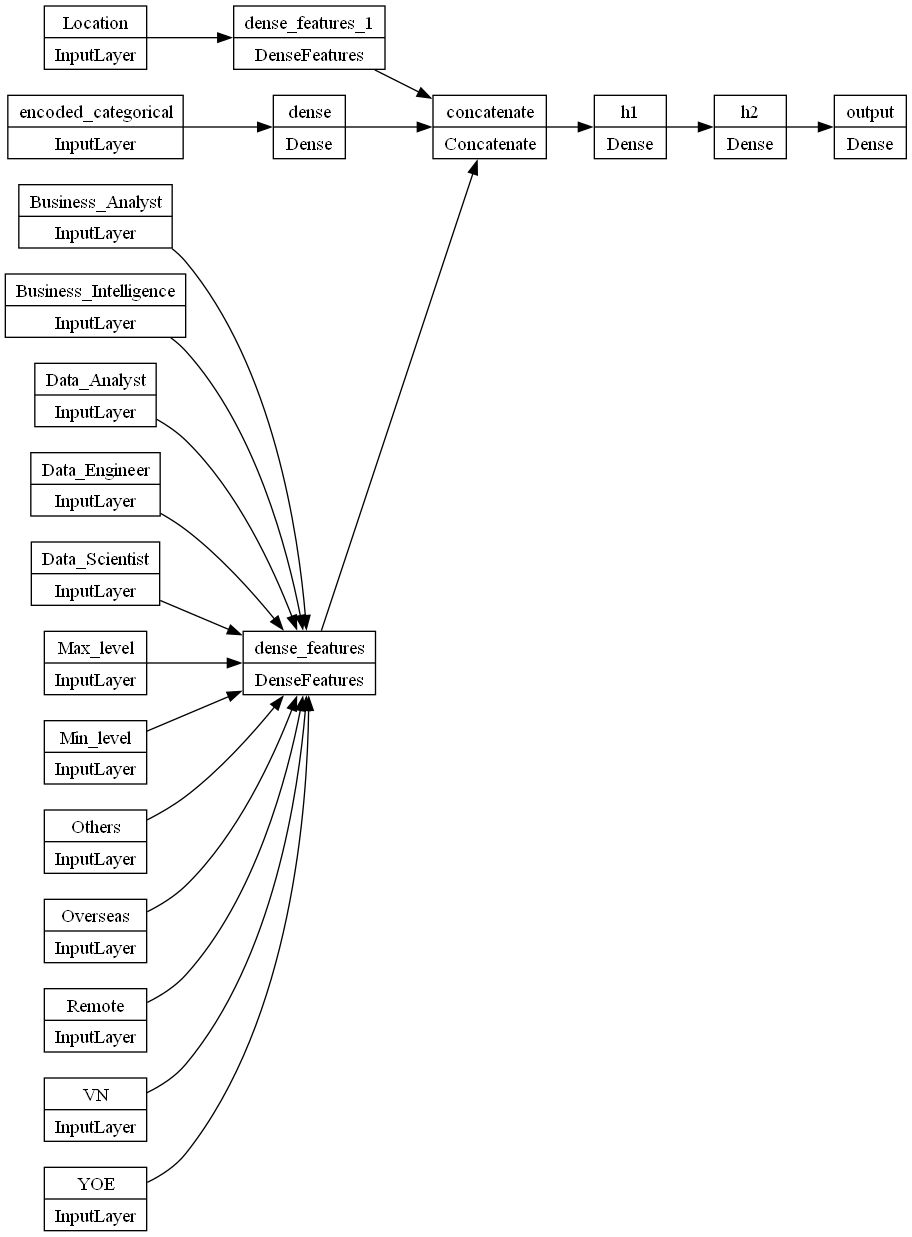

In [13]:
# Save compiled model into a variable
keras_model = build_dnn_model()

# Plot the layer architecture and relationship between input features
tf.keras.utils.plot_model(keras_model, 'dnn_model.png', show_shapes=False, rankdir='LR')

With the model architecture defined it is time to train it!

## Train the model

You are going to train the model for 20 epochs using a batch size of 32.

In [14]:
NUM_EPOCHS = 20
TRAIN_BATCH_SIZE = 32
NUM_TRAIN_EXAMPLES = len(load_dataset(clean_df,'train'))
NUM_EVAL_EXAMPLES = len(load_dataset(clean_df,'eval'))

Use the previously defined function to load the datasets from the original csv files.

In [15]:
# Training dataset
trainds = load_dataset(clean_df, TRAIN_BATCH_SIZE, 'train')

# Evaluation dataset
evalds = load_dataset(clean_df, 1000, 'eval').take(NUM_EVAL_EXAMPLES//1000)

# Needs to be specified since the dataset is infinite
# This happens because the repeat method was used when creating the dataset
steps_per_epoch = NUM_TRAIN_EXAMPLES // TRAIN_BATCH_SIZE

# Train the model and save the history
history = model.fit(trainds,
                    validation_data=evalds,
                    epochs=NUM_EPOCHS,
                    steps_per_epoch=steps_per_epoch)

NameError: name 'model' is not defined

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras import layers, models
NUM_EPOCHS=20
TRAIN_BATCH_SIZE=4
# Assuming clean_df is your DataFrame
X = clean_df.drop('Est_Salary', axis=1)
y = clean_df['Est_Salary']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# One-hot encode the categorical column 'Location'
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
X_train_encoded = encoder.fit_transform(X_train[['Location']])
X_val_encoded = encoder.transform(X_val[['Location']])

# Build the model
numeric_input = layers.Input(shape=(X_train.shape[1] - 1,), name='numeric_input')
location_input = layers.Input(shape=(X_train_encoded.shape[1],), name='location_input')

dense_numeric = layers.Dense(32, activation='relu')(numeric_input)
dense_numeric = layers.Dense(16, activation='relu')(dense_numeric)

concatenated_inputs = layers.concatenate([dense_numeric, location_input])

dense_combined = layers.Dense(8, activation='relu')(concatenated_inputs)

output_layer = layers.Dense(1, activation='linear', name='output')(dense_combined)

model = models.Model(inputs=[numeric_input, location_input], outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(
    {'numeric_input': X_train.drop('Location', axis=1).to_numpy(), 'location_input': X_train_encoded},
    y_train,
    epochs=NUM_EPOCHS,
    batch_size=TRAIN_BATCH_SIZE,
    verbose =2,
    validation_data=(
        {'numeric_input': X_val.drop('Location', axis=1).to_numpy(), 'location_input': X_val_encoded},
        y_val
    )
)

# Evaluate the model on the validation set
val_predictions = model.predict(
    {'numeric_input': X_val.drop('Location', axis=1).to_numpy(), 'location_input': X_val_encoded}
)
val_mse = mean_squared_error(y_val, val_predictions)
val_mae = mean_absolute_error(y_val, val_predictions)

print(f'Validation MSE: {val_mse}')
print(f'Validation MAE: {val_mae}')


Epoch 1/20


c:\Users\PC\miniconda3\envs\data_venv\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


726/726 - 2s - loss: 5309522.0000 - mae: 1540.3439 - val_loss: 2649715.2500 - val_mae: 1004.2386 - 2s/epoch - 3ms/step
Epoch 2/20
726/726 - 1s - loss: 3220777.5000 - mae: 1075.2361 - val_loss: 2542508.2500 - val_mae: 955.8239 - 1s/epoch - 2ms/step
Epoch 3/20
726/726 - 1s - loss: 3151740.5000 - mae: 1056.1296 - val_loss: 2466593.7500 - val_mae: 925.2232 - 1s/epoch - 2ms/step
Epoch 4/20
726/726 - 1s - loss: 3094777.0000 - mae: 1038.0259 - val_loss: 2409055.7500 - val_mae: 931.8275 - 1s/epoch - 2ms/step
Epoch 5/20
726/726 - 1s - loss: 3037503.7500 - mae: 1032.6604 - val_loss: 2345772.2500 - val_mae: 880.4140 - 1s/epoch - 2ms/step
Epoch 6/20
726/726 - 1s - loss: 2992548.0000 - mae: 1017.8545 - val_loss: 2291413.5000 - val_mae: 886.6585 - 1s/epoch - 2ms/step
Epoch 7/20
726/726 - 1s - loss: 2951816.7500 - mae: 1008.8586 - val_loss: 2255306.7500 - val_mae: 888.9640 - 1s/epoch - 2ms/step
Epoch 8/20
726/726 - 1s - loss: 2916765.5000 - mae: 1001.1181 - val_loss: 2235406.5000 - val_mae: 898.4830 

### Visualize training curves

Now lets visualize the training history of the model with the raw features:

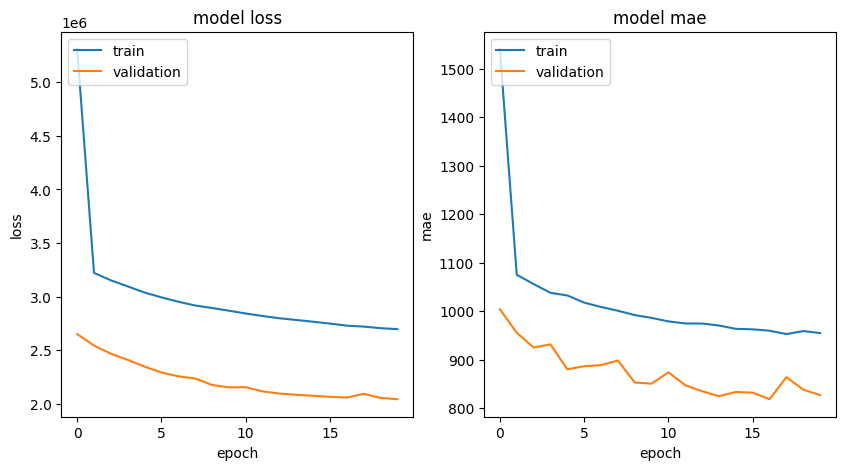

In [19]:
# Function for plotting metrics for a given history
def plot_curves(history, metrics):
    nrows = 1
    ncols = 2
    fig = plt.figure(figsize=(10, 5))

    for idx, key in enumerate(metrics):
        ax = fig.add_subplot(nrows, ncols, idx+1)
        plt.plot(history.history[key])
        plt.plot(history.history[f'val_{key}'])
        plt.title(f'model {key}')
        plt.ylabel(key)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')


# Plot history metrics
plot_curves(history, ['loss', 'mae'])

The training history doesn't look very promising showing an erratic behaviour.

The model MAE is more than $800. Considering average salary is $2400, this is far than optiomal

## Improve Model Performance Using Feature Engineering

We have JD as an important feature that has not been utilized in any way

In [ ]:
# extract skills

# grouping skills

# engineer the skills related features

### Applying transformations

Now you will define the `transform` function which will apply the previously defined transformation functions. To apply the actual transformations you will be using `Lambda` layers apply a function to values (in this case the inputs).


In [ ]:
def transform(inputs, numeric_cols):

    # Make a copy of the inputs to apply the transformations to
    transformed = inputs.copy()

    # Define feature columns
    feature_columns = {
        colname: tf.feature_column.numeric_column(colname)
        for colname in numeric_cols
    }

    # Scaling longitude from range [-70, -78] to [0, 1]
    for lon_col in ['pickup_longitude', 'dropoff_longitude']:
        transformed[lon_col] = layers.Lambda(
            scale_longitude,
            name=f"scale_{lon_col}")(inputs[lon_col])

    # Scaling latitude from range [37, 45] to [0, 1]
    for lat_col in ['pickup_latitude', 'dropoff_latitude']:
        transformed[lat_col] = layers.Lambda(
            scale_latitude,
            name=f'scale_{lat_col}')(inputs[lat_col])

    # add Euclidean distance
    transformed['euclidean'] = layers.Lambda(
        euclidean,
        name='euclidean')([inputs['pickup_longitude'],
                           inputs['pickup_latitude'],
                           inputs['dropoff_longitude'],
                           inputs['dropoff_latitude']])


    # Add euclidean distance to feature columns
    feature_columns['euclidean'] = fc.numeric_column('euclidean')

    return transformed, feature_columns

## Update the model

Next, you'll create the DNN model now with the engineered (transformed) features.

In [ ]:
def build_dnn_model():

    # input layer (notice type of float32 since features are numeric)
    inputs = {
        colname: layers.Input(name=colname, shape=(), dtype='float32')
        for colname in NUMERIC_COLS
    }

    # transformed features
    transformed, feature_columns = transform(inputs, numeric_cols=NUMERIC_COLS)

    # Constructor for DenseFeatures takes a list of numeric columns
    # and the resulting tensor takes a dictionary of Lambda layers
    dnn_inputs = layers.DenseFeatures(feature_columns.values())(transformed)

    # two hidden layers of 32 and 8 units, respectively
    h1 = layers.Dense(32, activation='relu', name='h1')(dnn_inputs)
    h2 = layers.Dense(8, activation='relu', name='h2')(h1)

    # final output is a linear activation because this is a regression problem
    output = layers.Dense(1, activation='linear', name='fare')(h2)

    # Create model with inputs and output
    model = models.Model(inputs, output)

    # Compile model (Mean Squared Error is suitable for regression)
    model.compile(optimizer='adam',
                  loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse'), 'mse'])

    return model

In [ ]:
# Save compiled model into a variable
model = build_dnn_model()

Let's see how the model architecture has changed.

In [ ]:
# Plot the layer architecture and relationship between input features
tf.keras.utils.plot_model(model, 'dnn_model_engineered.png', show_shapes=False, rankdir='LR')

This plot is very useful for understanding the relationships and dependencies between the original and the transformed features!

**Notice that the input of the model now consists of 5 features instead of the original 7, thus reducing the dimensionality of the problem.**

Let's now train the model that includes feature engineering.

In [ ]:
# Train the model and save the history
history = model.fit(trainds,
                    validation_data=evalds,
                    epochs=NUM_EPOCHS,
                    steps_per_epoch=steps_per_epoch)

In [ ]:
# Plot history metrics
plot_curves(history, ['loss', 'mse'])

In [ ]:
# Use the model to predict
prediction = model.predict(taxi_ride, steps=1)

# Print prediction
print(f"the model predicted a fare total of {float(prediction):.2f} USD for the ride.")